In [25]:
import re

import joblib
import pandas as pd
from pandarallel import pandarallel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('back')
from app import preprocess

pandarallel.initialize(progress_bar=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Preprocessing

In [22]:
df = pd.read_csv('back/data/jokes.csv')
df.head()

,theme,text,rating
0,pro-sudey,На суде в Стамбуле обвиняемый сказал:\r\n- На...,5
1,pro-sudey,"- Вы продолжаете утверждать, что обвиняемый н...",4
2,pro-sudey,"На суде.\r\n- Итак, когда дело дошло до столкн...",0
3,pro-sudey,Старую леди сбил автомобиль. На суде ее спраши...,4
4,pro-sudey,"Судья говорит:\r\n- Согласно вашей жалобе, об...",2


In [26]:
df['text'] = df['text'].parallel_apply(preprocess.lemmatize) 

In [27]:
df['rating'] = (df['rating'] - df['rating'].min())/(df['rating'].max() - df['rating'].min())*100.

<Axes: >

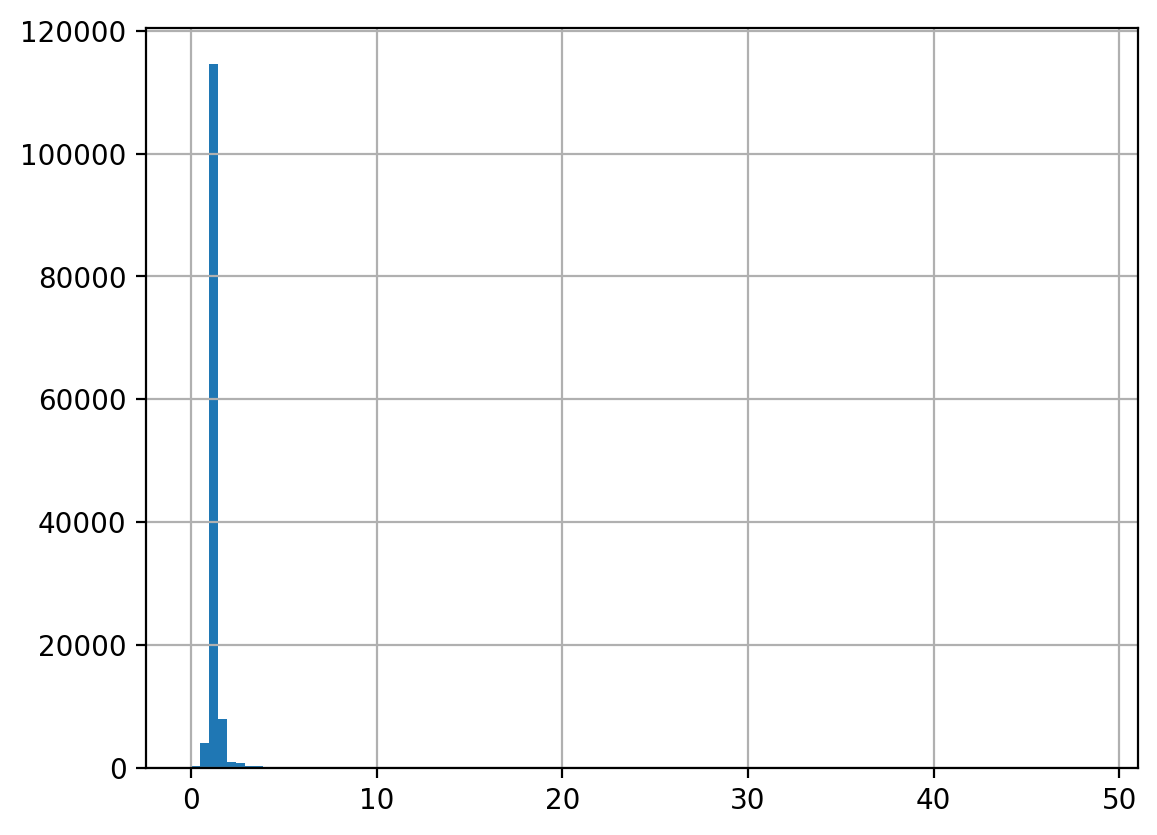

In [30]:
df[df['rating'] < 50]['rating'].hist(bins=100)

In [28]:
df['rating'].describe()

count    130204.000000
mean          1.385562
std           1.377449
min           0.000000
25%           1.277955
50%           1.277955
75%           1.277955
max         100.000000
Name: rating, dtype: float64

In [29]:
df['rating'].quantile(q=.99)

np.float64(3.5143769968051117)

In [30]:
df[df['rating'] > 3.5].shape[0]

1314

In [31]:
df[df['rating'] > 3.5].shape[0]*100./df.shape[0]

1.009185585696292

In [32]:
df['theme'].value_counts()

theme
raznie                     41988
aforizmi                   35532
tsitati                    13386
pro-semyu                   5794
pro-militsiyu               2867
pro-armiu                   2270
poshlie-i-intimnie          2148
pro-detey                   2096
meditsinskie                1990
pro-mugchin                 1899
shkolnie-i-pro-shkolu       1609
pro-studentov               1463
narodnie                    1441
pro-vovochku                1323
pro-alkogolikov             1148
pro-novih-russkih           1037
pro-evreev                  1029
pro-narkomanov               984
pro-shtirlitsa               965
pro-programmistov            758
pro-teshu                    740
pro-kino                     619
pro-sport-pro-futbol         590
pro-kompyuteri               579
sovetskie                    561
pro-givotnih                 548
pro-inostrantsev             540
cherniy-yumor                523
skazochnie                   507
dorognie-pro-dorogu          469
pro-

## Training

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
  df['text'], df['rating'], test_size=0.3, random_state=42
)

In [34]:
baseline_pipeline = Pipeline(steps=[
  ('vectorizer', TfidfVectorizer()),
  ('model', DummyRegressor())
])

baseline_pipeline.fit(X_train, y_train)

baseline_mse = mean_squared_error(
  baseline_pipeline.predict(X_test),
  y_test
)

print(baseline_mse)

1.5304261477697982


### Linear Regression

In [35]:
lr_pipeline = Pipeline(steps=[
  ('vectorizer', TfidfVectorizer()),
  ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

lr_mse = mean_squared_error(
  lr_pipeline.predict(X_test),
  y_test
)

print(lr_mse)
joblib.dump(lr_pipeline, 'back/models/lr.pkl')

9.514520560532903


['back/models/lr.pkl']

### Decision Tree Regressor

In [36]:
tr_pipeline = Pipeline(steps=[
  ('vectorizer', TfidfVectorizer()),
  ('model', DecisionTreeRegressor())
])

tr_pipeline.fit(X_train, y_train)

tr_mse = mean_squared_error(
  tr_pipeline.predict(X_test),
  y_test
)

print(tr_mse)
joblib.dump(tr_pipeline, 'back/models/tr.pkl')

1.5328206762210421


['back/models/tr.pkl']

## Test

In [56]:
model = joblib.load('back/models/tr.pkl')
print(str(model.steps[-1][1]))

DecisionTreeRegressor()


In [38]:
df['pred_rating'] = model.predict(df['text'])

In [44]:
model.predict([preprocess.lemmatize('идет смерть по улице, несет блины на блюдце')])

array([1.27795527])

In [43]:
df

,theme,text,rating,pred_rating
0,pro-sudey,суд стамбул обвиняемый свой жертва нападать но...,2.875399,2.236422
1,pro-sudey,продолжать утверждать обвиняемый назвать дурак...,2.555911,2.555911
2,pro-sudey,суд итак дело дойти столкновение противник рук...,1.277955,1.277955
3,pro-sudey,старый леди сбить автомобиль суд спрашивать де...,2.555911,2.555911
4,pro-sudey,судья говорить согласно вашея жалоба обвиняемы...,1.916933,1.916933
...,...,...,...,...
130199,raznie,збежать медведь зоопарк передать радио написат...,1.277955,1.277955
130200,raznie,разговаривать грузин гоги авас эх авас трахать...,1.277955,1.277955
130201,raznie,спать гений крепкий,1.277955,1.277955
130202,raznie,очередь последнея нея стоить бабка горбатый но...,1.277955,1.277955
